In [137]:
from scipy import io
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from tqdm import tqdm_notebook
from tqdm import tqdm
from collections import deque
from time import time

In [138]:
ROOT = "../PHBS_multi-factor_project/002 src/08 multiFactorModelPython"
sytleFactorDir = ROOT + "/bigDataProjectData/styleFactor/styleFactors_20191231.mat"
industryFactorDir = ROOT + "/bigDataProjectData/industryFactor/industryFactor_20191231.mat"
alphaFactorDir = ROOT + "/bigDataProjectData/orthFactorExposure/ortheFactors_20200102_2.mat"
closeDir = ROOT + "/bigDataProjectData/closeStock.mat"

In [ ]:
# mat = io.loadmat('yourfile.mat')
alphaFactorMat = io.loadmat(alphaFactorDir)
print(alphaFactorMat.keys())
alphaFactorCube = alphaFactorMat['orthFactors'][0][0][0]
print('alphaFactorCube:', alphaFactorCube.shape)

sytleFactorMat = io.loadmat(sytleFactorDir)
print(sytleFactorMat.keys())
sytleFactorCube = sytleFactorMat['styleSTR'][0][0][1]
print('sytleFactorCube:', sytleFactorCube.shape)

industryFactorMat = h5py.File(industryFactorDir)
print(industryFactorMat.keys())
industryFactorCube = np.transpose(industryFactorMat['industryFactor'])
print('industryFactorCube:', industryFactorCube.shape)

closeMat = io.loadmat(closeDir)
print(closeMat.keys())
close = closeMat['close']
print('close:', close.shape)


dict_keys(['__header__', '__version__', '__globals__', 'orthFactors', '__function_workspace__'])
alphaFactorCube: (2166, 3842, 29)
dict_keys(['__header__', '__version__', '__globals__', 'styleSTR'])
sytleFactorCube: (2166, 3842, 9)


C:\Users\Evan\AppData\Local\conda\conda\envs\env_futures\lib\site-packages\ipykernel_launcher.py:12: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  if sys.path[0] == '':


<KeysViewHDF5 ['industryFactor']>


In [91]:
class MultiFactorModelTest():
    def __init__(self, close, industryFactorCube, sytleFactorCube, alphaFactorCube, d_timeShift = 1 ):
        self.returnTable = (pd.DataFrame(close)-pd.DataFrame(close).shift(1))/pd.DataFrame(close).shift(1)
        self.shiftedReturnTable = self.returnTable.shift(-d_timeShift)
        self.industryFactorCube = industryFactorCube
        self.sytleFactorCube = sytleFactorCube
        self.alphaFactorCube = alphaFactorCube
        
    def getTimesliceData(self, timeslice, *args):
        output = []
        for cube in args:
            if np.ndim(cube)>2:
                output.append(cube[timeslice, :, :])
            else:
                output.append(cube[timeslice, :].reshape(-1,1))
        return(output)
    
    def setDTimeShift(self, d_timeShift):
        self.shiftedReturnTable = self.returnTable.shift(-d_timeShift)
        
    def getMeanReturn(self, toWeightReturn):
        return(toWeightReturn.mean(0))
    
    def modelTest(self, toTestAlphaCube, shiftedReturnTable = None, industryFactorCube = None, sytleFactorCube = None, getWeightExpectReturn = None,backTestDays = 200, T = 1, isLinearModel = True):
        if not industryFactorCube:
            industryFactorCube = self.industryFactorCube
        if not sytleFactorCube:
            sytleFactorCube = self.sytleFactorCube
        if not getWeightExpectReturn:
            getWeightExpectReturn = self.getMeanReturn
        if not shiftedReturnTable:
            shiftedReturnTable = self.shiftedReturnTable
            
        #         screanTable from outside    
        ####################################################
        stockScreanTable = np.ones(shiftedReturnTable.shape)
        ####################################################
        
        if np.ndim(toTestAlphaCube)==2:
            allXCount = industryFactorCube.shape[-1] +sytleFactorCube.shape[-1]+1
        else:
            allXCount = industryFactorCube.shape[-1] +sytleFactorCube.shape[-1] +toTestAlphaCube.shape[-1]
        factorReturnTable = np.zeros((shiftedReturnTable.shape[0], allXCount))
        predictReturnTable = np.empty(shiftedReturnTable.shape)
        modelIC = np.zeros(shiftedReturnTable.shape[0])
        
        modelQueue = deque(maxlen=T)
        for timeslice in tqdm_notebook(range(shiftedReturnTable.shape[0]-backTestDays, shiftedReturnTable.shape[0]-1)):
    
#             tqdm.write("start process:"+str(timeslice))
            starttime= time()

            #slice each table using timeslice
            X_industry, X_style, X_alpha = self.getTimesliceData(timeslice,
                                                                 industryFactorCube,
                                                                 sytleFactorCube, 
                                                                 toTestAlphaCube)
            alphaCount = X_alpha.shape[-1]

            stockScrean = stockScreanTable[timeslice, :]
            y_shiftedReturn = shiftedReturnTable.loc[timeslice]

            #mask to get valid datas(company):validToCal
            X_all = np.concatenate([X_industry, X_style, X_alpha], axis= 1)
            toMask = np.concatenate([np.array(y_shiftedReturn).reshape(-1, 1), X_all],axis = 1)
            finiteIndex = np.isfinite(toMask).all(axis = 1)
            validIndex = np.logical_and(finiteIndex,  stockScrean.astype(bool))
            validToCal = toMask[validIndex, :]

            # rank issue here
            X = validToCal[:, 1:]
            y = validToCal[:, 0]

            # check if all the model is ready, if true, predict next day epsilon with previos models
            if len(modelQueue)==T:

                # predict with pass T days model, get mean of all predection
                toWeightReturn = np.empty((T, shiftedReturnTable.shape[1]))
                for i, aModel in enumerate(modelQueue):
                    if isLinearModel:
                        
                        epsilon = aModel.coef_[-alphaCount:].dot(X[:, -alphaCount:].T)
                        toWeightReturn[i, validIndex] = epsilon
                    else:
                        toWeightReturn[i, validIndex] = aModel.predict(X)
                # get mean     
                predictReturn = getWeightExpectReturn(toWeightReturn)
                predictReturnTable[timeslice] = predictReturn

                #record the ic of today
                modelIC[timeslice] = np.corrcoef(predictReturn[validIndex], y)[0,1]

            # fit new model using today alpha exposure and next day's return
            # adjust for all kinds of models later
            model = LinearRegression(fit_intercept=False, n_jobs = 5)
            model.fit(X, y)
            modelQueue.append(model)

            # save the factor return(beta of the model)
            if isLinearModel:
                todayFReturn = model.coef_
                factorReturnTable[timeslice, :] = todayFReturn
                
#             tqdm.write("end of process, use time:"+str(-starttime+time()))
        #         return
        return(modelIC, predictReturnTable, factorReturnTable)
    
    def singleFactorTest(self, indexToTest, doPlot = True, backTestDays = 200, T = 1):
        toTestAlphaCube = self.alphaFactorCube[:, :, indexToTest]
        modelIC, predictReturnTable, factorReturnTable = self.modelTest(toTestAlphaCube, backTestDays = backTestDays, T = T)
        if doPlot:
            plt.figure(figsize = (15, 6))
            plt.title('IC of alpha number:'+str(indexToTest))
            plt.plot(modelIC[-backTestDays:-1],'-o', ms = 3)
            plt.hlines(0, 0, backTestDays)
            plt.hlines(modelIC[-backTestDays:-1].mean(), -1, 1)
            
        print("modelIC mean of alpha index ", indexToTest, ":", modelIC[-backTestDays:-1].mean())
        return(modelIC, predictReturnTable, factorReturnTable)
    
    def singleFactorTestAll(self, doPlot = True, backTestDays = 200, T = 1):
        modelICs = {}
        predictReturnTables = {}
        factorReturnTables = {}
        alphaCount = alphaFactorCube.shape[-1]
        
        if doPlot:
            fig = plt.figure(figsize=(45, (alphaCount//3+1)*10))
            
        for i in tqdm_notebook(range(alphaCount)):
            modelIC, predictReturnTable, factorReturnTable = self.singleFactorTest(i, False, backTestDays, T)
            modelICs.update({
                i:modelIC
            })
            predictReturnTables.update({
                i:predictReturnTable
            })
            factorReturnTables.update({
                i:factorReturnTables
            })
            if doPlot:
                plt.subplot(alphaCount//3+1, 3, i+1)
                plt.plot(modelIC[-backTestDays:-1],'-o', ms = 3)
                plt.title('IC of alpha number:'+str(i))
                plt.hlines(0, 0, backTestDays)
                
        if doPlot:
            plt.savefig("alphaIC.png")
                
        return(modelICs, predictReturnTables, factorReturnTables)
            
        
        


        


modelIC mean of alpha index  17 : 0.009955581307751045


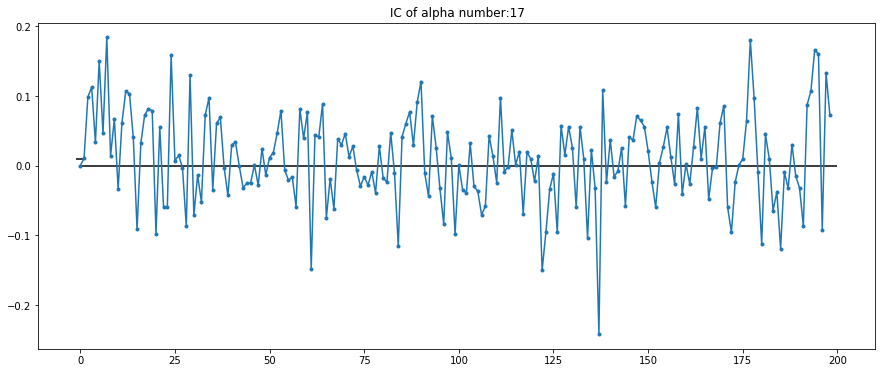

In [112]:
Klass = MultiFactorModelTest(close, industryFactorCube, sytleFactorCube, alphaFactorCube, d_timeShift = 1 )
Klass.setDTimeShift(1)
modelIC, predictReturnTable, factorReturnTable = Klass.singleFactorTest(17, True, 200)


In [136]:
# pd.concat([pd.DataFrame(modelIC[-200:]), pd.DataFrame(factorReturnTable[-200:, -1])],axis = 1).loc[135:, :]

pd.DataFrame(alphaFactorCube[-200:-1, :, 17]).loc[135:]

,0,1,2,3,4,5,6,7,8,9,...,3832,3833,3834,3835,3836,3837,3838,3839,3840,3841
135,0.973629,0.693544,NaN,-0.057203,-0.574215,-0.013537,1.584669,0.258927,-2.467222,-0.380029,...,0.112088,-1.962820,-0.956595,0.354286,-1.175209,-1.219184,-1.089008,-1.342175,-1.403457,-0.943131
136,0.978383,0.687824,NaN,-0.224862,-0.655223,-0.216300,1.673007,0.234794,-2.318034,-0.720969,...,0.039820,-1.888004,-0.891454,0.324725,-1.109109,-1.187727,-1.065904,-1.304382,-1.358488,-0.915763
137,0.973754,0.620117,NaN,-0.242546,-0.389478,-0.161849,1.733604,0.184747,-1.886711,-0.885253,...,-0.041939,-1.864975,-0.832373,0.260105,-1.055204,-1.093877,-0.962540,-1.221909,-1.345732,-0.828443
138,0.938020,0.543965,NaN,-0.101145,-0.167062,0.052033,1.806769,0.179470,-1.785968,-1.079221,...,-0.143923,-1.804974,-0.799436,0.159656,-1.019220,-1.006704,-0.875124,-1.139383,-1.297730,-0.749178
139,0.916582,0.447696,NaN,-0.107758,-0.041672,0.218517,2.923006,0.138492,-1.828395,-1.059939,...,-0.219020,-1.646361,-0.653978,0.096212,-0.868261,-0.857145,-0.723963,-0.987588,-1.130842,-0.602478
140,0.915765,0.263489,NaN,0.144308,0.522476,0.619276,3.146870,0.062899,-1.535340,-0.819332,...,-0.374768,-1.495927,-0.504840,-0.073610,-0.718525,-0.706633,-0.573290,-0.837028,-0.981636,-0.453006
141,0.875059,0.180721,NaN,0.262832,0.834341,0.645539,2.593374,-0.007957,-1.209572,-0.488975,...,-0.371223,-1.366804,-0.454939,-0.112904,-0.656307,-0.501724,-0.368754,-0.645113,-0.927449,-0.286095
142,0.872877,0.081764,NaN,0.194910,1.329656,0.774072,2.391754,-0.140530,-0.833069,-0.174645,...,-0.387968,-1.173808,-0.315490,-0.165522,-0.509128,-0.320438,-0.195560,-0.462726,-0.783885,-0.122769
143,0.756011,-0.028473,NaN,0.174586,1.533173,0.839444,2.251574,-0.205679,-0.579190,0.017375,...,-0.338226,-1.087404,-0.295248,-0.179885,-0.469193,-0.194375,-0.061111,-0.341154,-0.703804,-0.022735
144,0.676829,-0.199346,NaN,0.170121,1.480040,0.735266,2.120626,-0.271757,-0.493525,0.058701,...,-0.344163,-0.997472,-0.229054,-0.237566,-0.397465,-0.137275,-0.007988,-0.278537,-0.619172,0.031121


In [107]:
modelIC

array([0.        , 0.        , 0.        , ..., 0.11022699, 0.09475177,
       0.        ])

modelIC mean of alpha index  0 : 0.0001336497735847854


modelIC mean of alpha index  1 : 0.00047688085041371043


modelIC mean of alpha index  2 : 0.000804937235622098


modelIC mean of alpha index  3 : 0.0013015582192878244


modelIC mean of alpha index  4 : -0.00012613975596128927


modelIC mean of alpha index  5 : 0.0006409384137231406


modelIC mean of alpha index  6 : 0.0002962804421141505


modelIC mean of alpha index  7 : -0.00014336880817256248


modelIC mean of alpha index  8 : 0.0005913083502566268


modelIC mean of alpha index  9 : 0.001478180349811155


modelIC mean of alpha index  10 : 0.001268947660007101


modelIC mean of alpha index  11 : 0.0014456377409196811


modelIC mean of alpha index  12 : 0.00024681382985788203


modelIC mean of alpha index  13 : 0.0005963644307202606


modelIC mean of alpha index  14 : 0.0001023485714120014


modelIC mean of alpha index  15 : 0.001559072693917936


modelIC mean of alpha index  16 : 8.527785203101987e-05


modelIC mean of alpha index  17 : 0.0009146632872772197


modelIC mean of alpha index  18 : 0.005634395335457963


modelIC mean of alpha index  19 : 0.0004121400883151912


modelIC mean of alpha index  20 : 0.0010389200957529904


modelIC mean of alpha index  21 : 0.0009142591691969484


modelIC mean of alpha index  22 : 0.001952227454441531


modelIC mean of alpha index  23 : 0.0013104153866695695


modelIC mean of alpha index  24 : 0.0015080631653686205


modelIC mean of alpha index  25 : 0.0002661371290215415


modelIC mean of alpha index  26 : -0.0005146763082236332


modelIC mean of alpha index  27 : 0.0008227908138262068


modelIC mean of alpha index  28 : 0.00038779239424222006



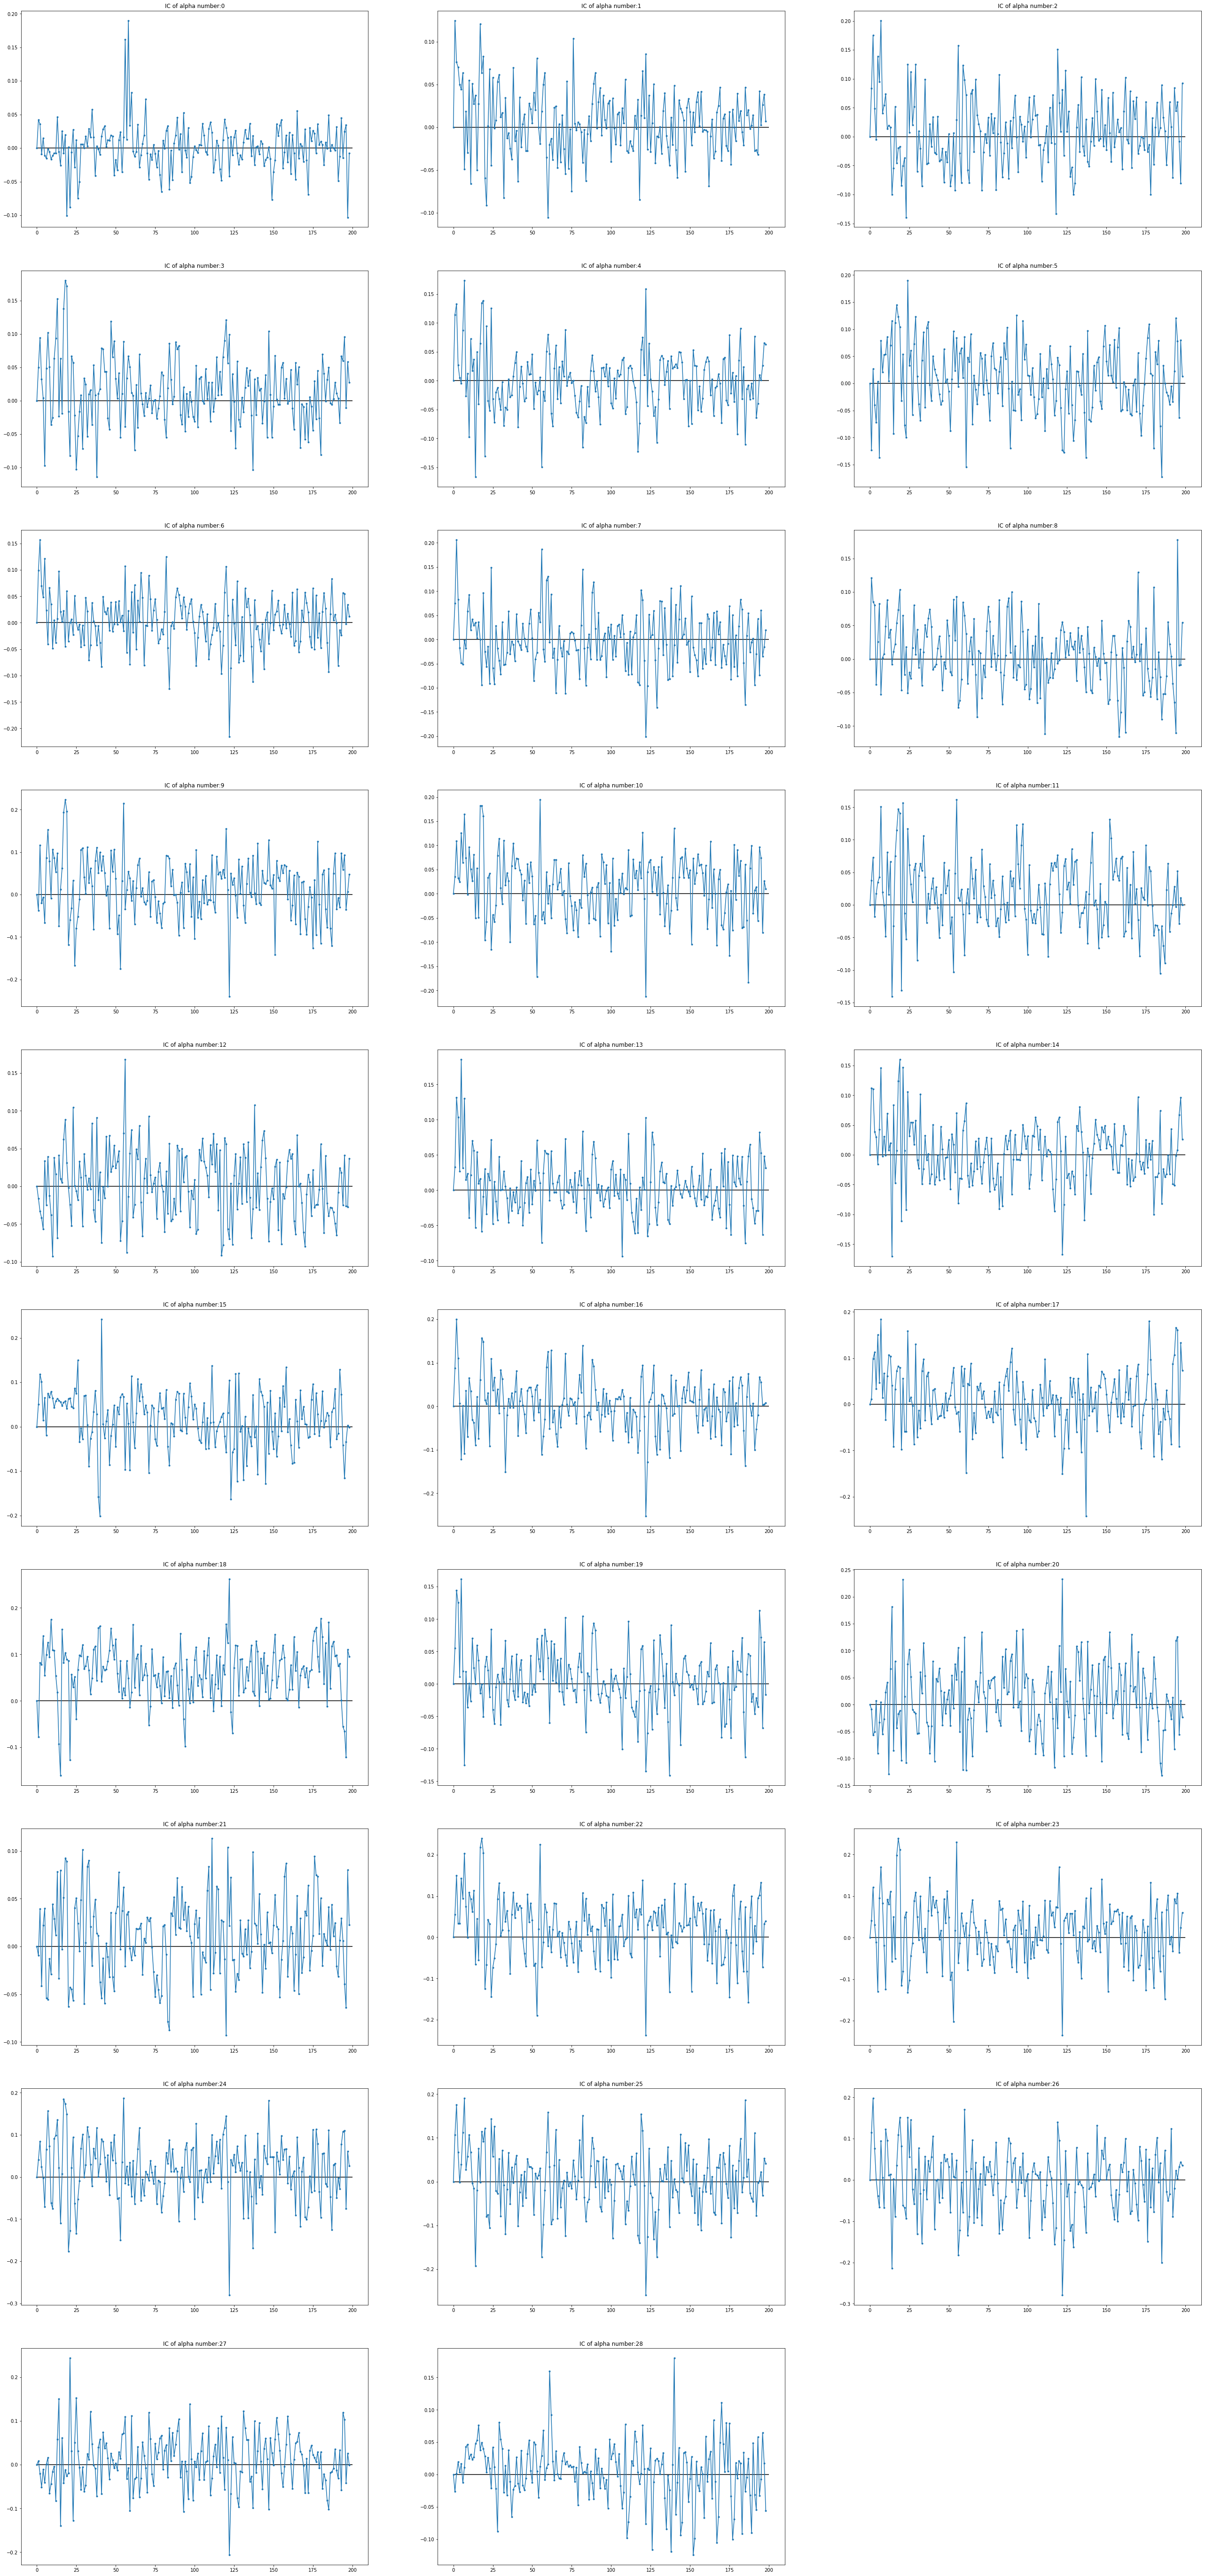

In [56]:
# modelIC, predictReturnTable, factorReturnTable = Klass.modelTest(Klass.alphaFactorCube[:, :, 6])
modelICs, predictReturnTables, factorReturnTables = Klass.singleFactorTestAll()